In [48]:
from fastgraphml.graph_embeddings import SAGE
from fastgraphml.graph_embeddings import downstream_tasks 
from arango import ArangoClient
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [2]:
# Initialize the ArangoDB client.
client = ArangoClient("http://127.0.0.1:8529")
db = client.db('_system', username='root')

In [3]:
# Loading ArangoDB Graph
arango_graph = db.graph('amazon_computer_graph')

# metadata information of arango_graph
metagraph = {
    "vertexCollections": {
        "Computer_Products": {"x": "features", "y": "label"}, # mapping features attribute present in collection to x (node feature)
                                                              # mapping label attribute present in collection to y (node label)
    },
    "edgeCollections": {
        "bought_together": {},
    },
}

In [4]:
# generating graph embeddings with 3 lines of code
model = SAGE(db, arango_graph, metagraph, embedding_size=256) # define graph embedding model
model._train(epochs=6, lr=0.0001) # train
embeddings = model.get_embeddings() # get embeddings

[2022/10/06 15:47:30 +0530] [12030] [INFO] - adbpyg_adapter: Instantiated ADBPYG_Adapter with database '_system'
bought_together: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 491722/491722 [00:03<00:00, 154025.32it/s]
[2022/10/06 15:47:36 +0530] [12030] [INFO] - adbpyg_adapter: Created PyG '<Graph amazon_computer_graph>' Graph


Homogeneous Graph Detected ........ 

{'Nodes': 13471, 'Node_feature_size': 767, 'Number_of_classes': 10, 'Edges': 491722, 'Edge_feature_fize': None, 'Graph Directionality': 'Undirected', 'Average node degree': '36.50', 'Number of training nodes': 10777, 'Number of val nodes': 1347, 'Number of test nodes': 1347, 'Has isolated nodes': False}
Training started .........
Epoch: 001, Train_Loss: 1.3626, Val: 0.7996, Test: 0.8048
Val Acc increased (0.00000 --> 0.79955).  Saving model ...
Epoch: 002, Train_Loss: 1.2654, Val: 0.8211, Test: 0.8233
Val Acc increased (0.79955 --> 0.82108).  Saving model ...
Epoch: 003, Train_Loss: 1.1866, Val: 0.8300, Test: 0.8315
Val Acc increased (0.82108 --> 0.82999).  Saving model ...
Epoch: 004, Train_Loss: 1.0630, Val: 0.8293, Test: 0.8344
Epoch: 005, Train_Loss: 1.0818, Val: 0.8352, Test: 0.8382
Val Acc increased (0.82999 --> 0.83519).  Saving model ...


## Graph Embeddings Visualization

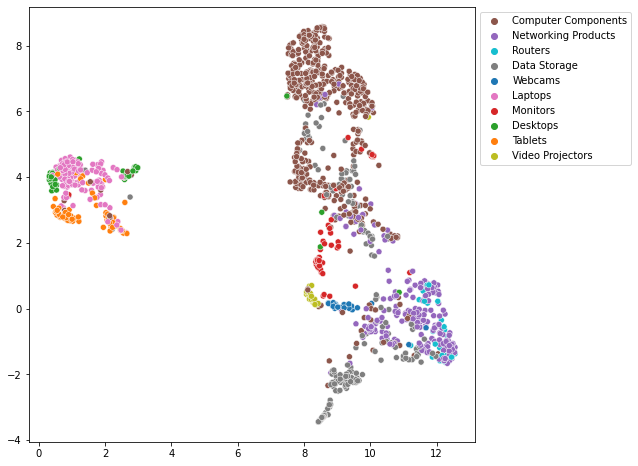

In [6]:
class_names = {0: 'Desktops',1: 'Data Storage',2: 'Laptops',3: 'Monitors',4: 'Computer Components',
 5: 'Video Projectors',6: 'Routers',7: 'Tablets',8: 'Networking Products',9: 'Webcams'}

# emb visualization
# model.G access PyG data object
downstream_tasks.visualize_embeddings(model.G, embeddings, class_mapping=class_names) 

## Similarity Search/Recommendation

In [30]:
# returns top 50 similar products (ids) along with similarity distance 
distance, nbors = downstream_tasks.similarity_search(embeddings, top_k_nbors=50)

In [45]:
# Let's pick a random computer prodcut
# model.G.y access PyG node labels
class_names[model.G.y[5].item()]

'Data Storage'

In [44]:
# recommend computer product that can be bought together with 'Data Storage' product
class_names[model.G.y[nbors[5][40]].item()]

'Networking Products'

## Node Classification with Graph Embeddings

In real world most of the datasets are without labels (or have few labels) and often imbalanced. The class imbalance and sparse labels make supervised learning a challenging task. It can also lead to higher false negatives and imbalanced datasets can result in models with more false positives. Hence, training GNNs with unsupervised objectives and using their latent representaion (node embeddings) downstream can provide promising results. Once graph (node) embeddings are generated using unsupervised learning, it can be used as a feature inputs to machine learning classification models to perform the task of node classification. 

Below code shows that even less amount of training data (with labels) i.e 10% can generalize well on the unseen data (test data) which is in contrast with above SAGE class where we have used 80% of data as training to test the performance of generated graph embeddings.

In [60]:
# Dataset Splitting
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, model.G.y, train_size=0.1, test_size=None, stratify=model.G.y, random_state=42)

In [61]:
# Training with Logistic Regression
clf = LogisticRegression(max_iter=1000, solver="lbfgs")
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [62]:
y_pred = clf.predict(X_test)
# evalute accuracy on test set
accuracy_score(y_test, y_pred)

0.8094688221709007

## Store Graph Embeddings in ArangoDB

In [11]:
model.graph_util.store_embeddings(embeddings, collection_name='computer_products_embeddings', batch_size=100,
                                 class_mapping=class_names, nearest_nbors_search=True)

Output()

Inserting batch the last batch!